In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from neuralprophet import NeuralProphet
import plotly.io as pio #some neural prophet images are made using plotly which provides interactive widgets(VERY COOL) but unfortunately in order to see them the entire code must be ran.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

D:\Anaconda\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
df = pd.read_csv('NSRDB_data.csv',
                index_col = [0])

df.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,DNI,Fill Flag,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016,1,1,0,0,5.0,0,0,0,0,...,0,0,0,49.00,168.95,0.128,990,0.472,55.7,4.0
2016-01-01 00:30:00,2016,1,1,0,30,5.0,0,0,0,0,...,0,0,0,49.00,166.74,0.128,990,0.477,55.7,4.0
2016-01-01 01:00:00,2016,1,1,1,0,5.0,0,0,0,0,...,0,0,0,48.97,162.23,0.128,990,0.482,55.7,4.1
2016-01-01 01:30:00,2016,1,1,1,30,5.0,0,0,0,0,...,0,0,0,48.97,156.74,0.128,990,0.489,55.7,4.1
2016-01-01 02:00:00,2016,1,1,2,0,5.0,0,0,0,0,...,0,0,0,48.98,150.83,0.128,990,0.496,56.0,4.2


In order for a prophet model to work I need to have a column titled ds for datetime(also in datetime type) and a column labeled y for what we are trying to predict.  In this case it will be the GHI.

In [3]:
# Creating the new DataFrame with just the index and 'GHI' column,
# resetting the index, and renaming columns in one step
df_prophet = df[['GHI']].reset_index().rename(columns={'datetime': 'ds', 'GHI': 'y'})

# Displaying the new DataFrame
df_prophet.head(2)

,ds,y
0,2016-01-01 00:00:00,0
1,2016-01-01 00:30:00,0


In [ ]:
#https://github.com/facebook/prophet/issues/1829
#helped me with the train size creation

---
## Neural Prophet

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df.index)  # Convert index to datetime type
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.dayofweek
    df['Minute'] = df['datetime'].dt.quarter
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    
    X = df[['Hour', 'Day', 'Month', 'Year', 'Minute']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='GHI')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
features_and_target

,Hour,Day,Month,Year,Minute,GHI
datetime,,,,,,
2016-01-01 00:00:00,0,4,1,2016,1,0
2016-01-01 00:30:00,0,4,1,2016,1,0
2016-01-01 01:00:00,1,4,1,2016,1,0
2016-01-01 01:30:00,1,4,1,2016,1,0
2016-01-01 02:00:00,2,4,1,2016,1,0
...,...,...,...,...,...,...
2020-12-31 21:30:00,21,3,12,2020,4,0
2020-12-31 22:00:00,22,3,12,2020,4,0
2020-12-31 22:30:00,22,3,12,2020,4,0


### Looking at the Trends by the Set Features from Above

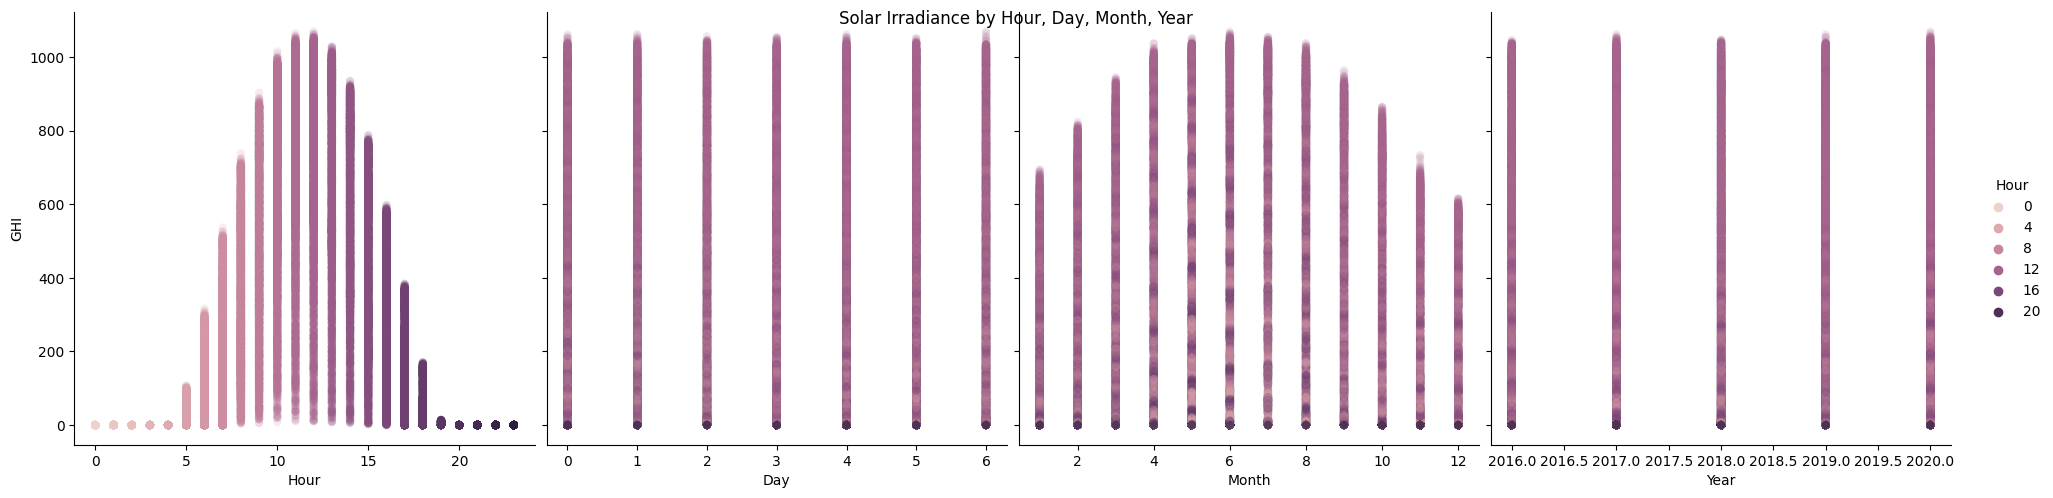

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='Hour',
             x_vars=['Hour','Day',
                     'Month','Year'],
             y_vars='GHI',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Solar Irradiance by Hour, Day, Month, Year')
plt.show()

### Train-Test Split

In [7]:
date_split = '2020-10-01'
train = df.loc[df.index <= date_split].copy()
test = df.loc[df.index > date_split].copy()

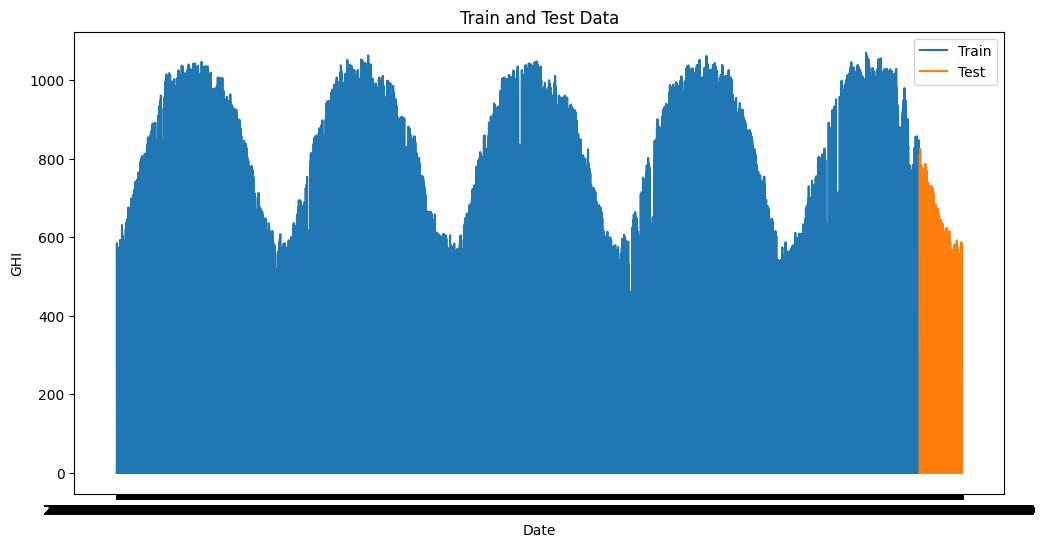

In [8]:
# Plot train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['GHI'], label='Train')
plt.plot(test.index, test['GHI'], label='Test')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.title('Train and Test Data')
plt.legend()
plt.show()

**The image above is to visualize the train and testing data**

## Simple Prophet, will add params later

In [9]:
train.head(2)

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,DNI,Fill Flag,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016,1,1,0,0,5.0,0,0,0,0,...,0,0,0,49.0,168.95,0.128,990,0.472,55.7,4.0
2016-01-01 00:30:00,2016,1,1,0,30,5.0,0,0,0,0,...,0,0,0,49.0,166.74,0.128,990,0.477,55.7,4.0


In [10]:
train.reset_index(inplace = True)

In [11]:
train.rename(columns={'datetime': 'ds', 'GHI': 'y'}, inplace=True)
train['ds'] = pd.to_datetime(train['ds'])
ghi_train = train[['ds', 'y']]
ghi_train.head()

,ds,y
0,2016-01-01 00:00:00,0
1,2016-01-01 00:30:00,0
2,2016-01-01 01:00:00,0
3,2016-01-01 01:30:00,0
4,2016-01-01 02:00:00,0


In [12]:
ghi_train.dtypes

ds    datetime64[ns]
y              int64
dtype: object

**I set up a very basic neural prophet model with a batch_size of 64(default), and 60 epochs(default).  The time frequency is set to 30T(30 minute time intervals) to match our datetime index.**

In [13]:
model = NeuralProphet()
model.fit(ghi_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60


Finding best initial lr:   0%|          | 0/273 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,964.132874,1147.796631,0.517461,0.0,0
1,146.200653,182.381317,0.018353,0.0,1
2,92.453506,124.155876,0.007261,0.0,2
3,91.531288,123.397766,0.007212,0.0,3
4,92.383453,124.725304,0.007383,0.0,4
5,94.026031,126.951492,0.007647,0.0,5
6,95.562920,128.936478,0.007882,0.0,6
7,97.100571,130.897232,0.008137,0.0,7
8,98.609428,132.550537,0.008342,0.0,8
9,100.279663,134.899750,0.008616,0.0,9


In [14]:
test.reset_index(inplace = True)

In [15]:
test.rename(columns={'datetime': 'ds', 'GHI': 'y'}, inplace=True)
test['ds'] = pd.to_datetime(test['ds'])
ghi_test = test[['ds', 'y']]
ghi_test.head()

,ds,y
0,2020-10-01 00:00:00,0
1,2020-10-01 00:30:00,0
2,2020-10-01 01:00:00,0
3,2020-10-01 01:30:00,0
4,2020-10-01 02:00:00,0


In [16]:
ghi_forecast = model.predict(df = ghi_test)
ghi_forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T


Predicting: 1302it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
0,2020-10-01 00:00:00,0,9.437808,237.840500,2.009907,-0.448610,-229.963989
1,2020-10-01 00:30:00,0,9.176524,237.841476,1.990602,-0.467066,-230.188492
2,2020-10-01 01:00:00,0,8.915348,237.842468,1.971296,-0.482819,-230.415588
3,2020-10-01 01:30:00,0,9.076279,237.843430,1.951990,-0.495672,-230.223465
4,2020-10-01 02:00:00,0,9.729206,237.844437,1.932683,-0.505431,-229.542480


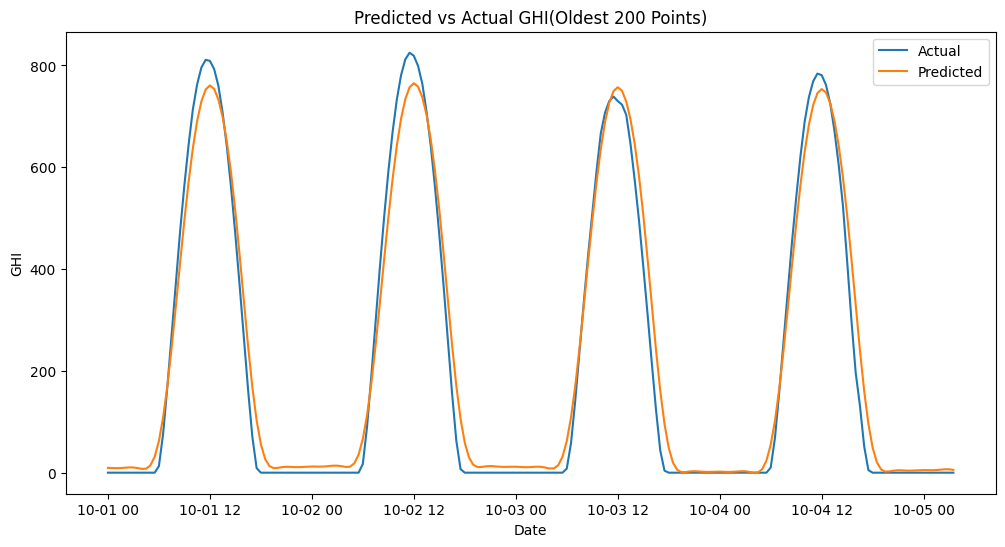

In [25]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(test['ds'][0:200], test['y'][0:200], label='Actual')
ax.plot(ghi_forecast['ds'][0:200], ghi_forecast['yhat1'][0:200], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('GHI')
ax.set_title('Predicted vs Actual GHI(Oldest 200 Points)')
ax.legend()
plt.savefig('images_prophet/pred_v_actual_oldest.png')

**The image above is the first 200 entries from the testing data and the first 200 entries from forecast data. These are plotted in a 30 minute time interval.  The frequency of the model was set to 30T automatically since that is the format of our data.**

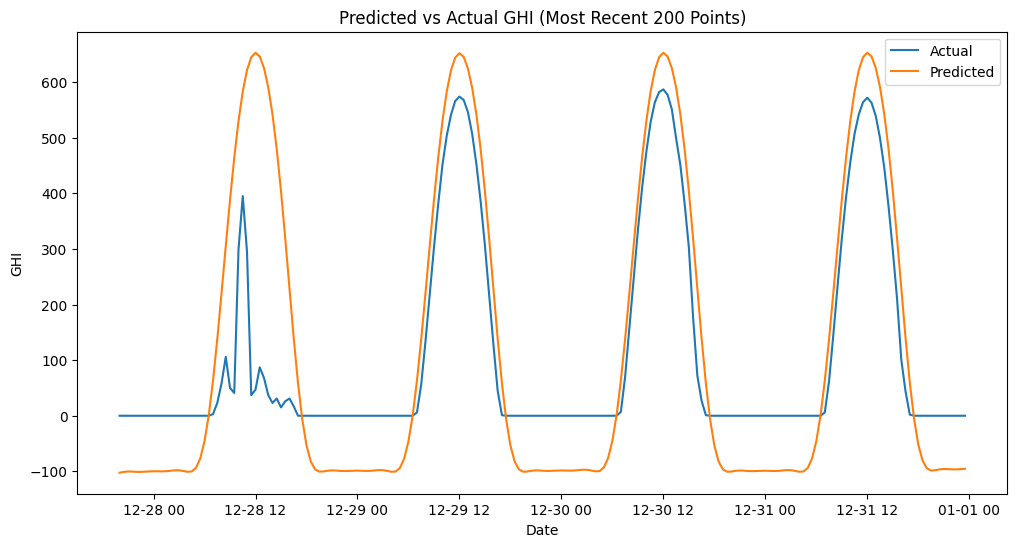

In [24]:
num_dates = 200  # Number of most recent dates to select

# Select the most recent dates and their corresponding values
recent_ghi_forecast = ghi_forecast.tail(num_dates)
recent_test = test.tail(num_dates)

# Plot the most recent dates
f, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(recent_test['ds'], recent_test['y'], label='Actual')
ax.plot(recent_ghi_forecast['ds'], recent_ghi_forecast['yhat1'], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('GHI')
ax.set_title('Predicted vs Actual GHI (Most Recent 200 Points)')
ax.legend()
plt.savefig('images_prophet/pred_v_actual_recent.png')

**The image about shows the most recent 200 entries for the predicted and the actual values.These are plotted in a 30 minute time interval.  The frequency of the model was set to 30T automatically since that is the format of our data.**

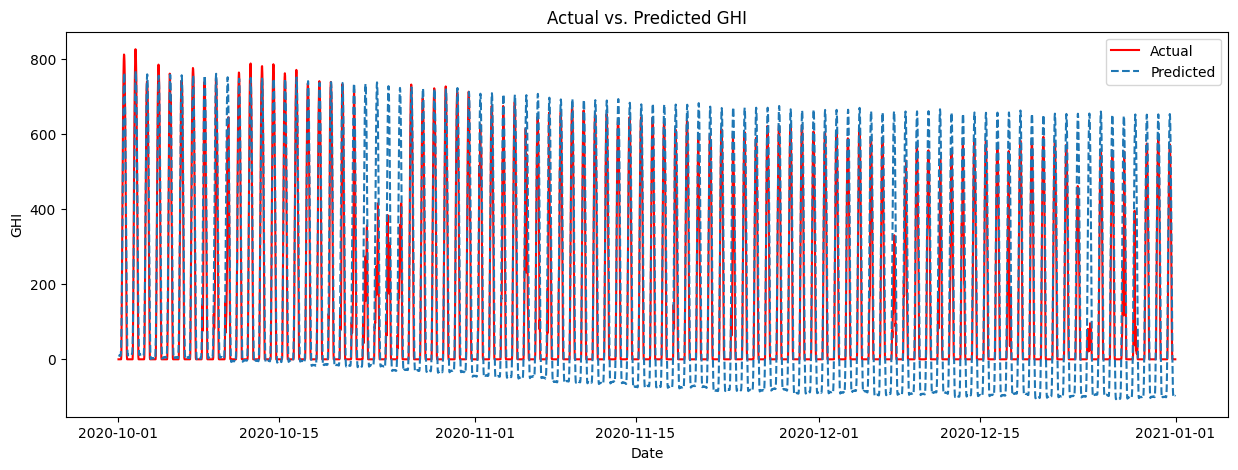

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(ghi_forecast['ds'], ghi_forecast['y'], label='Actual', color = 'r')
ax.plot(ghi_forecast['ds'], ghi_forecast['yhat1'], label='Predicted',  linestyle = 'dashed')

ax.set_xlabel('Date')
ax.set_ylabel('GHI')
ax.set_title('Actual vs. Predicted GHI')
ax.legend()
plt.show()

**The image above shows the 3 month sample that was used for the testing data. The blue dashed line is the predicted value and the red is the actual.**

In [23]:
fig = model.plot_components(ghi_forecast)
pio.write_image(fig, 'images_prophet/forecast_component_plots.png')

In [26]:
#The image for the components plots has to be saved as a static image since Neural Prophet uses plotly, it provides an interactive widget.
#https://plotly.com/python/static-image-export/ thank you Eric for the link.
fig

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~2h</i>',
              'showlegend': False,
              'type': 'scatter',
              'uid': '660ab1b7-3571-4111-99dd-143f95396726',
              'x': array([datetime.datetime(2020, 10, 1, 0, 0),
                          datetime.datetime(2020, 10, 1, 1, 30),
                          datetime.datetime(2020, 10, 1, 3, 30), ...,
                          datetime.datetime(2020, 12, 31, 19, 0),
                          datetime.datetime(2020, 12, 31, 22, 0),
                          datetime.datetime(2020, 12, 31, 23, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([237.84049988, 237.84342957, 237.84736633, ..., 242.17564392,
                          242.18156433, 242.18449402]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'wi

![The image above shows the components of the forecast.](images_prophet/forecast_component_plots.png)

**The image above shows the components of the forecast.**

In [19]:
mean_squared_error(y_true=test['y'],
                   y_pred=ghi_forecast['yhat1'])

11573.838845666818

In [20]:
mean_absolute_error(y_true=test['y'],
                   y_pred=ghi_forecast['yhat1'])

76.2996236942506

In [21]:
r2 = r2_score(y_true=test['y'], y_pred=ghi_forecast['yhat1'])
print("R-squared:", r2)

R-squared: 0.7841895647296391


In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=test['y'], y_pred=ghi_forecast['yhat1'])
print("MAPE:", mape)

MAPE: inf


*NOTE: In this case the MAPE does not work since GHI has 0 values. I think if I play around with it a bit more I can change the outcome for this.*